# Homework 0: Build Neural Language Model and N-Gram language model for text generation

Build a text generator based on n-gram language model and neural language model.
1.	Find a corpus (e.g. http://www.lib.ru/SHAKESPEARE/hamlet2.txt), but you are free to use anything else of your interest
2.	Preprocess it if necessary (we suggest using nltk for that)
3.	Build an n-gram model
4.	Try out different values of n, calculate perplexity on a held-out set
5.	Build a simple neural network model for text generation (start from a feed-forward net for example). We suggest using tensorflow + keras for this task

Criteria:
1.	Data is split into train / validation / test, motivation for the split method is given
2.	N-gram model is implemented
3.	Neural network for text generation is implemented
4.	Perplexity is calculated for both models
5.	Examples of texts generated with different models are present and compared


# Libraries

In [61]:
%autosave 180
%load_ext autoreload
%autoreload 2

%matplotlib inline

from ipywidgets import IntProgress

import requests
import pprint
from copy import copy
from itertools import repeat
import re, collections, functools, operator, string, sys, random, os
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import islice
from tqdm import tqdm
from scipy import spatial
from sklearn.model_selection import ParameterGrid


import nltk
!pip install --upgrade nltk
nltk.download("all")
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import pad_sequence
from nltk.util import bigrams, trigrams, ngrams, everygrams
from nltk.lm.preprocessing import pad_both_ends, flatten
from nltk.lm import MLE
from collections import Counter, defaultdict
from nltk.stem.snowball import SnowballStemmer

import gensim

from pymystem3 import Mystem
!pip install --upgrade pymorphy2
import pymorphy2
from sklearn.model_selection import train_test_split


import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Activation, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.activations import softmax
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
#from keras_tqdm import TQDMNotebookCallback, TQDMCallback

import logging
logging.basicConfig(level=logging.INFO, format='%(levelname)-9s [%(asctime)s] : %(message)s', stream=sys.stdout)

Autosaving every 180 seconds
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Requirement already up-to-date: nltk in /usr/local/lib/python3.6/dist-packages (3.4.5)
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    | 

In [62]:
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  TPU_ADDRESS  = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', TPU_ADDRESS )
  tf.logging.set_verbosity(tf.logging.INFO)

  with tf.Session(TPU_ADDRESS ) as session:
    devices = session.list_devices()
    
  print('We have {} TPU devices:'.format(len(devices)))
  pprint.pprint(devices)

# ' ' means CPU whereas '/device:G:0' means GPU
# tf.test.gpu_device_name()

TPU address is grpc://10.89.163.162:8470
We have 11 TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 7322844466005819914),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 17896851653582348032),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 16808068830790172628),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 15796122849580108111),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 3873793192331902691),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 15518806637752033744),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 3768795297449820052),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 5904609071165959228),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 

In [0]:
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm() 

# Corpus

## Find a corpus

For this task I chose Dante's 'Divine Comedy' in Russian. It's main advantage is that it is long enough to fit every interested model

In [0]:
corpus_url = 'http://lib.ru/POEZIQ/DANTE/comedy.txt'
#corpus_fedot = 'http://lib.ru/ANEKDOTY/fedot.txt'

In [65]:
# getting webpage with needed text and then converting the responce into Unicode
response = requests.get(corpus_url)
raw_corpus = response.text

raw_corpus[:25000]

'<html><head><title>Данте Алигьери. Божественная комедия</title></head><body><pre><div align=right><form action=/POEZIQ/DANTE/comedy.txt><select name=format><OPTION VALUE="_Contents">Содержание<OPTION VALUE="_with-big-pictures.html">Fine HTML<OPTION VALUE="_with-big-pictures.html">Printed version<OPTION VALUE="_Ascii.txt">txt(Word,КПК)<OPTION VALUE="">Lib.ru html</select><input type=submit value=go></form></div><pre>\n<ul><a name=0></a><h2>Данте Алигьери. Божественная комедия</h2></ul>\n\n----------------------------------------------------------------------------\n     Перевод М.Лозинского\n     ББК 84.4 Ит\n         Д 17\n     Издательство "Правда", М.: 1982\n     OCR Бычков М.Н.\n----------------------------------------------------------------------------\n\n     "Божественная Комедия" возникла в тревожные ранние  годы  XIV  века  из\nбурливших напряженной политической борьбой глубин национальной жизни Италии.\nДля будущих  -  близких  и  далеких  -  поколений  она  осталась  велича

## Preprocessing

In [66]:
#At first we need to remove html-tags from corpus. 
#We know that these tags are located between <> symbols
#so it is easy to remove tags via regexp
TAG_RE = re.compile(r'<[^>]+>')
corpus = TAG_RE.sub('', raw_corpus)


#There is some foreword at the beginning, but we are 
#gonna deal only with the poem so we need to cut hte foreword. 
#We know that the poem starts from chapter named 'АД' so we can cut all before this word
first_chapter_index = corpus.find("АД")
corpus = corpus[first_chapter_index:]


#The same thing we will do with remarks and comments after text. 
#They follow after word 'ПРИМЕЧАНИЯ'
remarks_index = corpus.find('ПРИМЕЧАНИЯ')
corpus = corpus[:remarks_index]


#In addition we are to remove names of chapters and parts of the poem to avoid 
#frequent occurances with words "ПЕСНЬ" and so on

# remove all patterns, containing from 1 to 3 words of 2 and more caps letters
chapter_RE = re.compile(r'([А-Я]{2,}){1,3}')
corpus = re.sub(chapter_RE, ' ', corpus)

corpus[:1000]

'  * \n\n   \n\n                    1 Земную жизнь пройдя до половины,\n                      Я очутился в сумрачном лесу,\n                      Утратив правый путь во тьме долины.\n\n                    4 Каков он был, о, как произнесу,\n                      Тот дикий лес, дремучий и грозящий,\n                      Чей давний ужас в памяти несу!\n\n                    7 Так горек он, что смерть едва ль не слаще.\n                      Но, благо в нем обретши навсегда,\n                      Скажу про все, что видел в этой чаще.\n\n                   10 Не помню сам, как я вошел туда,\n                      Настолько сон меня опутал ложью,\n                      Когда я сбился с верного следа.\n\n                   13 Но к холмному приблизившись подножью,\n                      Которым замыкался этот дол,\n                      Мне сжавший сердце ужасом и дрожью,\n\n                   16 Я увидал, едва глаза возвел,\n                      Что свет планеты, всюду путеводной,\n       

Now in variable *corpus* we have only needed poem. But it isn't clear now

In [67]:
corpus = corpus.lower()

# we don't need numbers used to indicate lines
corpus = re.sub(r"\d+", "", corpus)

conversion_table = str.maketrans({key: '' for key in string.punctuation})
corpus = corpus.translate(conversion_table)

corpus[:1000]

'   \n\n   \n\n                     земную жизнь пройдя до половины\n                      я очутился в сумрачном лесу\n                      утратив правый путь во тьме долины\n\n                     каков он был о как произнесу\n                      тот дикий лес дремучий и грозящий\n                      чей давний ужас в памяти несу\n\n                     так горек он что смерть едва ль не слаще\n                      но благо в нем обретши навсегда\n                      скажу про все что видел в этой чаще\n\n                    не помню сам как я вошел туда\n                      настолько сон меня опутал ложью\n                      когда я сбился с верного следа\n\n                    но к холмному приблизившись подножью\n                      которым замыкался этот дол\n                      мне сжавший сердце ужасом и дрожью\n\n                    я увидал едва глаза возвел\n                      что свет планеты всюду путеводной\n                      уже на плечи горные с

Let's consider the corpus as a set of poetic lines

In [68]:
corpus = re.sub(r" {2,}", " ", corpus)
corpus = re.split(r'[\n]{1,}', corpus)
corpus[:5]

[' ',
 ' ',
 ' земную жизнь пройдя до половины',
 ' я очутился в сумрачном лесу',
 ' утратив правый путь во тьме долины']

In [69]:
%%time 

morph = pymorphy2.MorphAnalyzer()
russian_stopwords = stopwords.words("russian")

# for i, line in enumerate(tqdm(corpus)):
#     #print('before:', line)
#     #corpus[i] = [morph.parse(word)[0].normal_form for word in line.split(' ') if not word in russian_stopwords]
#     corpus[i] = [word for word in line.split(' ') if not (word in russian_stopwords or word in [' ', ''])]
#     #print('after:', line)

corpus = [line.strip() for line in corpus if line != ' ']

INFO      [2019-11-02 09:31:05,036] : Loading dictionaries from /usr/local/lib/python3.6/dist-packages/pymorphy2_dicts/data
INFO      [2019-11-02 09:31:05,078] : format: 2.4, revision: 393442, updated: 2015-01-17T16:03:56.586168
CPU times: user 37.2 ms, sys: 13.4 ms, total: 50.6 ms
Wall time: 48.8 ms


In [70]:
display(corpus[:10], corpus[-10:])

['земную жизнь пройдя до половины',
 'я очутился в сумрачном лесу',
 'утратив правый путь во тьме долины',
 'каков он был о как произнесу',
 'тот дикий лес дремучий и грозящий',
 'чей давний ужас в памяти несу',
 'так горек он что смерть едва ль не слаще',
 'но благо в нем обретши навсегда',
 'скажу про все что видел в этой чаще',
 'не помню сам как я вошел туда']

['таков был я при новом диве том',
 'хотел постичь как сочетаны были',
 'лицо и круг в слиянии своем',
 'но собственных мне было мало крылий',
 'и тут в мой разум грянул блеск с высот',
 'неся свершенье всех его усилий',
 'здесь изнемог высокий духа взлет',
 'но страсть и волю мне уже стремила',
 'как если колесу дан ровный ход',
 'любовь что движет солнце и светила']

In [71]:
len(corpus)

14239

## Splitting data

I will split the text in 60/20/20 proportion with shuffling because I want all parts of the poem to be in each set.  
On the first 60% of data I will fit models, on the next 20% I will compare (and may be tune somehow) them. Final performance will be estimated on the remaiming 20%

In [0]:
#corpus = corpus[:1000]

In [0]:
train_sentences, test_sentences = train_test_split(corpus, train_size = 0.6, shuffle=False)

In [0]:
val_sentences, test_sentences = train_test_split(test_sentences, train_size = 0.5, shuffle=False)

In [75]:
print('train len:', len(train_sentences))

print('val len:', len(val_sentences))

print('test len:', len(test_sentences))

train len: 8543
val len: 2848
test len: 2848


## Limit used words if needed

In [76]:
train_occurances = Counter()

for sentence in tqdm(train_sentences):
    train_occurances.update(sentence.split(' '))

train_occurances = dict(
    sorted(train_occurances.items(), key=lambda x: x[1], reverse=True))

100%|██████████| 8543/8543 [00:00<00:00, 259255.33it/s]


In [77]:
len(train_occurances)

14060

In [0]:
vocab_len = 10000
vocab = []

In [0]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

vocab = take(vocab_len, train_occurances.keys())

# Funcs

In [0]:
def corpus2seq(list_of_sentences, pad_symbol, n, fixed_vocab=None):
    sequence_of_tokens = (pad_symbol.center(len(pad_symbol) + 2)*(n-1)).join(list_of_sentences).split()
    if fixed_vocab is not None:
        sequence_of_tokens = ['<UNK>' if word not in fixed_vocab else word for word in sequence_of_tokens]
    # padding
    sequence_of_tokens = list(pad_sequence(sequence_of_tokens, n, 
                                           pad_left=True, pad_right=True, 
                                           left_pad_symbol=pad_symbol,
                                           right_pad_symbol=pad_symbol))
    return sequence_of_tokens

## Estimating function

In [0]:
def perplexity(test_sentences, langauage_model, verbose=0):
    ''' Returns the perplexity of text based on the n-grams learned by
            this model '''
    
    sequence_of_tokens = (langauage_model.left_pad_symbol.center(len(langauage_model.left_pad_symbol) + 2)*(langauage_model.n-1)).join(test_sentences).split()

    if langauage_model.fixed_vocab is not None:
        sequence_of_tokens = ['<UNK>' if word not in langauage_model.fixed_vocab else word for word in sequence_of_tokens]
    
    # padding
    sequence_of_tokens = list(pad_sequence(sequence_of_tokens, langauage_model.n, 
                                            pad_left=True, pad_right=True, 
                                            left_pad_symbol=langauage_model.left_pad_symbol,
                                            right_pad_symbol=langauage_model.left_pad_symbol))
    
    #print('sequence_of_tokens', sequence_of_tokens[:100])
    
    # create ngrams of defined length
    ngrams = zip(*[sequence_of_tokens[i:] for i in range(langauage_model.n)])

    log2_probs = []

    for ngram in tqdm(ngrams, mininterval=10, total=len(sequence_of_tokens) - langauage_model.n + 1):
        context = tuple(ngram[:-1])
        word = ngram[-1]       
        prob = langauage_model.prob(word, context)
        log2_probs.append(np.log2(prob))
        if verbose == 1:
            print("P({}|{})={}".format(word, context, prob))
        if prob == 0:
            return np.inf

    return 2**(-sum(log2_probs) / len(sequence_of_tokens))

# Language models

## N-gram model

### Define N-gram model

In [0]:
class NgramModel():
    ''' A basic n-gram model using add-k smoothing '''

    
    def __init__(self, n, smoothing_parameter=0, left_pad_symbol='<s>', right_pad_symbol='</s>', fixed_vocab=None):
        
        assert n >= 1 , "'n' must be not less that 1"
      
        self.n = n
        self.left_pad_symbol = left_pad_symbol
        self.right_pad_symbol = right_pad_symbol
        self.smoothing_parameter = smoothing_parameter
        self.vocab = None
        self.fixed_vocab = fixed_vocab + [left_pad_symbol]
        
        self.occurances = defaultdict(lambda: defaultdict(lambda: 0))
        self.model = defaultdict(lambda: defaultdict(lambda: 0))

            
    def get_vocab(self, refresh=False):
        ''' Returns the set of characters in the vocab '''
      
        if refresh or self.vocab is None:
            contexts = list(self.occurances.keys())
            contexts_flatten = [item for sublist in contexts for item in sublist]
            self.vocab = set(contexts_flatten)
            
            for key in self.occurances.keys():
                #print('set(self.model[key].keys())', set(self.model[key].keys()))
                self.vocab = self.vocab.union(set(self.occurances[key].keys()))   

            # remove start and stop symbols
            #vocab = vocab.difference([self.left_pad_symbol, self.right_pad_symbol])
       
        return self.vocab
    
    
    def update_occurances(self, corpus):
        ''' Updates occurances of ngrams'''
        
        sequence_of_tokens = corpus2seq(corpus, self.left_pad_symbol, self.n, self.fixed_vocab)
        #print('sequence_of_tokens', sequence_of_tokens[:100])
        
        # create ngrams of defined length
        ngrams = zip(*[sequence_of_tokens[i:] for i in range(self.n)])
        
        # update occurances
        for ngram in ngrams:
            # add a 'point' for the context and the word after it
            self.occurances[tuple(ngram[:-1])][ngram[-1]] += 1
        
      
    def update_probs(self, 
                     #add_UNK=False, UNK_threshold = 2
                    ):
        ''' Updates the model using maximum likelihood estimates with or without smothing'''

        '''
         if add_UNK:
             # if vocab wasn't calculated before, we need to calculate it
             if self.vocab is None:
                 self.vocab=self.get_vocab(refresh=True)
                 #print('self.vocab', self.vocab)
           
             self.vocab = self.vocab.union({'<UNK>'})
       
             # count how many times each word occurred after any context
             word_occurances = dict.fromkeys(self.vocab, 0)
             for words_occurances_from_context in self.occurances.values():
                 word_occurances = dict(functools.reduce(operator.add, 
                                        map(collections.Counter, [word_occurances, words_occurances_from_context]))) 
               
             transform_to_UNK = [k for k,v in word_occurances.items() if v < UNK_threshold]
           
             for context in self.occurances.keys():
                 UNK_context_occurances = 0
                 for word, value in list(self.occurances[context].items()):
                     if word in transform_to_UNK:
                         UNK_context_occurances += value
                         del self.occurances[context][word]
                 if UNK_context_occurances != 0:
                     self.occurances[context]['<UNK>'] = UNK_context_occurances
                     UNK_context_occurances = 0
               
             # replace transform_to_UNK words in context
             # pop transform_to_UNK words from vocab
        '''
        
        # transforming the counts to probabilities, i.e. normalizing by unigrams
        # and storing it in model variable
        for context in self.occurances.keys():          
            logging.debug('context:{}'.format(context))
            context_occurances = float(sum(self.occurances[context].values()))
            logging.debug('context_occurances:{}'.format(context_occurances))
            
            # update default value if needed
            if self.smoothing_parameter != 0:
                self.model[context].default_factory  = lambda: (self.smoothing_parameter / (context_occurances + self.smoothing_parameter*len(self.get_vocab())))
            
            for word in self.occurances[context]:
                #print('context, word, self.occurances:', context, word, self.occurances[context][word])
                self.model[context][word] = (self.occurances[context][word] + self.smoothing_parameter) \
                    / (context_occurances + self.smoothing_parameter*len(self.get_vocab()))
        
        self.model.default_factory  = lambda: defaultdict(lambda: (1 / len(self.get_vocab())))
    
    
    def prob(self, word, context=()):
        ''' Returns the probability of a word appearing after context '''
        
        prob = self.model[context][word]
        logging.debug('prob from {} to {} equals {}'.format(context, word, prob))
        return prob


    def random_word_from_context(self, context, show_smoothing_prob=False):
        ''' Returns a random character based on the given context and the 
            n-grams learned by this model '''
        
        list_of_candidates = list(self.get_vocab())
        probability_distribution = [self.model[context][word] for word in list_of_candidates]
        # normalize the probabilities by dividing them by their sum because the sum is close enough to 1
        # it is needed because random.choice checks if sum of probs equals 1
        probability_distribution = np.array(list(probability_distribution))
        probability_distribution /= probability_distribution.sum()
        #print('probability_distribution:{}'.format(probability_distribution))
        
        return np.random.choice(list_of_candidates, p=probability_distribution)

    
    def random_text(self, length):
        ''' Returns text of the specified character length based on the
            n-grams learned by this model '''
        
        if self.n == 1:
            text_beginning = self.left_pad_symbol
        else:
            text_beginning = list(repeat(self.left_pad_symbol, self.n-1))        
        
        text = " ".join(list(text_beginning))

        for i in range(length):
            # next context contain last n-1 words
            if self.n == 1:
                context = ()
            else:
                context = tuple(text.split(' ')[-1 * self.n + 1:])
            
            word = self.random_word_from_context(context)
            text = ' '.join([text, word])
            
        return ' '.join([text, self.left_pad_symbol])

### Tune n-gram models

In [0]:
def tune_ngram(params_to_tune, fixed_vocab, train_sentences, val_sentences, 
               gen_text_length=100, process_generated_text=False):
    
    grid_list = list(ParameterGrid(params_to_tune))
    
    results = pd.DataFrame(columns=['params', 
                                    'train_perplexity',
                                    'val_perplexity',
                                    'raw_generated_text'])
    
    for param_set in tqdm(grid_list, total=len(grid_list)):
        logging.info('Current params set:{}'.format(param_set))
        model = NgramModel(n=param_set['n'], 
                           smoothing_parameter=param_set['smoothing_parameter'], 
                           fixed_vocab=fixed_vocab)
        
        model.update_occurances(train_sentences)
        model.update_probs()
        
        generated_text = model.random_text(gen_text_length)
        if process_generated_text:
            generated_text = re.sub(r'<UNK>', '', generated_text)
            print('generated text:\n', re.sub(r'(<s> ){1,}', '\n', generated_text))
        else:
            print('generated_text\n', generated_text)
        
        logging.info('Calculating perplexity for train')
        train_perplexity = perplexity(train_sentences, model)
        print('train_perplexity: {}'.format(train_perplexity))
        
        logging.info('Calculating perplexity for val')
        val_perplexity = perplexity(val_sentences, model)
        print('val_perplexity: {}'.format(val_perplexity))
    
        results.loc[len(results), results.columns] = {'n': param_set['n'], 
                                                      'smoothing_parameter': param_set['smoothing_parameter']}, \
                                                      train_perplexity, \
                                                      val_perplexity, \
                                                      generated_text
        
        logging.info('Current results\n{}'.format(results[results.columns[:-1]]))
        
    return results

In [119]:
%%time

params_to_tune = {
    'n': [2, 3, 4],
    'smoothing_parameter': [0.0001, 0.001, 0.01, 0.1, 0.5, 1]
}

ngram_tune_results = tune_ngram(params_to_tune, vocab, train_sentences, val_sentences,
                                gen_text_length=50, process_generated_text=False)

  0%|          | 0/18 [00:00<?, ?it/s]

INFO      [2019-11-02 15:45:45,204] : Current params set:{'n': 2, 'smoothing_parameter': 0.0001}
generated_text
 <s> сокровенный <s> и есть мы <UNK> <s> и тень перекаты понес спутника со разлита <s> как велики <s> большой слышно рассудку борн тот в себе <UNK> долгий век земной <s> которой повседневной былью <s> торопясь вперед сотню лет <s> он укроти <s> я вея <s> <UNK> <s> на скрывая облик <s>
INFO      [2019-11-02 15:45:51,679] : Calculating perplexity for train



100%|██████████| 57386/57386 [00:00<00:00, 161425.09it/s]

train_perplexity: 27.811987544119255
INFO      [2019-11-02 15:45:54,203] : Calculating perplexity for val



100%|██████████| 18847/18847 [00:00<00:00, 147619.96it/s]

val_perplexity: 298.2180166000346
INFO      [2019-11-02 15:45:55,285] : Current results
                                    params train_perplexity val_perplexity
0  {'n': 2, 'smoothing_parameter': 0.0001}           27.812        298.218


  6%|▌         | 1/18 [00:10<02:51, 10.08s/it]

INFO      [2019-11-02 15:45:55,288] : Current params set:{'n': 2, 'smoothing_parameter': 0.001}
generated_text
 <s> которой вправо стреле любил и коль небесах дознаться зло чью душу <UNK> <s> наружу итальянский благостный ты пенестрино клубе объем горла тосканский таинство разверз глазу смятением вручит бьют каковы оборотясь люцифера подняв лин твердо дружка волчицей немногие насевших призрак положен сомнением темя обернув присмотрела местом иосафата ней сечи восходит в <s>
INFO      [2019-11-02 15:46:01,957] : Calculating perplexity for train



100%|██████████| 57386/57386 [00:00<00:00, 73620.25it/s]

train_perplexity: 44.18606038060549
INFO      [2019-11-02 15:46:05,031] : Calculating perplexity for val



100%|██████████| 18847/18847 [00:00<00:00, 69994.69it/s]

val_perplexity: 241.979766807647
INFO      [2019-11-02 15:46:06,828] : Current results
                                    params train_perplexity val_perplexity
0  {'n': 2, 'smoothing_parameter': 0.0001}           27.812        298.218
1   {'n': 2, 'smoothing_parameter': 0.001}          44.1861         241.98


 11%|█         | 2/18 [00:21<02:48, 10.52s/it]

INFO      [2019-11-02 15:46:06,834] : Current params set:{'n': 2, 'smoothing_parameter': 0.01}
generated_text
 <s> благотворен вылетая бич бесконечным чужда повторял смотрит свершавшие трижды <UNK> вторя тянулся клоня ждет осталось жути ахерону аретинец всем постыл ужасом гонимых тифей утолишься даря сокола изогнул грешника ветер вовеки верховный фивы сами темной нынешнего колеса саладина полновластье свежим встает торчал вас турок возбраняя загривке роя рыдая повелел смутно нужда <s>
INFO      [2019-11-02 15:46:15,621] : Calculating perplexity for train



100%|██████████| 57386/57386 [00:00<00:00, 161144.64it/s]

train_perplexity: 112.32418390999351
INFO      [2019-11-02 15:46:18,151] : Calculating perplexity for val



100%|██████████| 18847/18847 [00:00<00:00, 149032.37it/s]

val_perplexity: 301.209909219477
INFO      [2019-11-02 15:46:19,228] : Current results
                                    params train_perplexity val_perplexity
0  {'n': 2, 'smoothing_parameter': 0.0001}           27.812        298.218
1   {'n': 2, 'smoothing_parameter': 0.001}          44.1861         241.98
2    {'n': 2, 'smoothing_parameter': 0.01}          112.324         301.21


 17%|█▋        | 3/18 [00:34<02:46, 11.08s/it]

INFO      [2019-11-02 15:46:19,230] : Current params set:{'n': 2, 'smoothing_parameter': 0.1}
generated_text
 <s> столького злится земные бурый горести вопиющей обволокли вступишь вложив смутен дзита тебальделло томим оказался правым нард почесть вскочил подземными наружность утесе братья истинный былые ранит полдневный заточенный равной поверх грани нашлась загребалам редко каясь читатель посла норовя наживешь виноватых горяч жгучего дала призваны неутомимый жестоким пляс решился ям подземною полны <s>
INFO      [2019-11-02 15:46:26,057] : Calculating perplexity for train



100%|██████████| 57386/57386 [00:00<00:00, 158329.66it/s]

train_perplexity: 431.2360817602933
INFO      [2019-11-02 15:46:28,597] : Calculating perplexity for val



100%|██████████| 18847/18847 [00:00<00:00, 146879.39it/s]

val_perplexity: 511.6864566261307
INFO      [2019-11-02 15:46:29,678] : Current results
                                    params train_perplexity val_perplexity
0  {'n': 2, 'smoothing_parameter': 0.0001}           27.812        298.218
1   {'n': 2, 'smoothing_parameter': 0.001}          44.1861         241.98
2    {'n': 2, 'smoothing_parameter': 0.01}          112.324         301.21
3     {'n': 2, 'smoothing_parameter': 0.1}          431.236        511.686


 22%|██▏       | 4/18 [00:44<02:32, 10.89s/it]

INFO      [2019-11-02 15:46:29,680] : Current params set:{'n': 2, 'smoothing_parameter': 0.5}
generated_text
 <s> произнесу бросился доверяет жизни невозделанный ногтей видя поддельщиков искусник сюда ведаешь смиренный посмотрев острие бригатой возрос сочетал водной зреет речах буйной стынет пресекши чего изведенный поломавший окунут плачущего корысть приязнью дуда коварный власти тут непроглядный придет жвачку ком застыла зерцалу дева побитый крадется просят минув добрались сияет дурны всечасной скат <s>
INFO      [2019-11-02 15:46:36,190] : Calculating perplexity for train



100%|██████████| 57386/57386 [00:00<00:00, 158207.38it/s]

train_perplexity: 1234.8320360795228
INFO      [2019-11-02 15:46:38,724] : Calculating perplexity for val



100%|██████████| 18847/18847 [00:00<00:00, 149851.09it/s]

val_perplexity: 909.1790292204112
INFO      [2019-11-02 15:46:39,800] : Current results
                                    params train_perplexity val_perplexity
0  {'n': 2, 'smoothing_parameter': 0.0001}           27.812        298.218
1   {'n': 2, 'smoothing_parameter': 0.001}          44.1861         241.98
2    {'n': 2, 'smoothing_parameter': 0.01}          112.324         301.21
3     {'n': 2, 'smoothing_parameter': 0.1}          431.236        511.686
4     {'n': 2, 'smoothing_parameter': 0.5}          1234.83        909.179


 28%|██▊       | 5/18 [00:54<02:18, 10.66s/it]

INFO      [2019-11-02 15:46:39,803] : Current params set:{'n': 2, 'smoothing_parameter': 1}
generated_text
 <s> мирные заточенный ухватил кстати претерпев направили извне встречал молодым поделом драться чреду искусстве несет твоя свиньи входом увидал просит лекарством убитый прильнул ее отошли вручил слетело густой бережней арене олютело ростом мгла посмотрев обретешь причиной помышлял передвигался пустынному исполнить кипучий отсюда благодатная фаэтон перенести увидав умер могучей годам папу огня <s>
INFO      [2019-11-02 15:46:46,658] : Calculating perplexity for train



100%|██████████| 57386/57386 [00:00<00:00, 159664.35it/s]

train_perplexity: 1873.8854890975822
INFO      [2019-11-02 15:46:49,182] : Calculating perplexity for val



100%|██████████| 18847/18847 [00:00<00:00, 145120.52it/s]

val_perplexity: 1218.4446203854877
INFO      [2019-11-02 15:46:50,262] : Current results
                                    params train_perplexity val_perplexity
0  {'n': 2, 'smoothing_parameter': 0.0001}           27.812        298.218
1   {'n': 2, 'smoothing_parameter': 0.001}          44.1861         241.98
2    {'n': 2, 'smoothing_parameter': 0.01}          112.324         301.21
3     {'n': 2, 'smoothing_parameter': 0.1}          431.236        511.686
4     {'n': 2, 'smoothing_parameter': 0.5}          1234.83        909.179
5       {'n': 2, 'smoothing_parameter': 1}          1873.89        1218.44


 33%|███▎      | 6/18 [01:05<02:07, 10.60s/it]

INFO      [2019-11-02 15:46:50,263] : Current params set:{'n': 3, 'smoothing_parameter': 0.0001}
generated_text
 <s> <s> а длиннее ветрила круглом смутился вилку сонма горше родства низменный измученной венчанная борьбе приговоре зубы пойду перуном восседает злодейства коса недальновидных множа исступленный гнуснейшим взорах прощенным леарха прорастет падай жил посереди ужасом шагало льдом мщенье пустынна озирали смотав хмурой пояса чугуна двум супруга унылый каин хвостач сообществе вождя награда скорбящий <s>
INFO      [2019-11-02 15:47:06,975] : Calculating perplexity for train



100%|██████████| 65929/65929 [00:00<00:00, 158623.76it/s]

train_perplexity: 6.188856465228507
INFO      [2019-11-02 15:47:10,414] : Calculating perplexity for val



100%|██████████| 21695/21695 [00:00<00:00, 122085.30it/s]

val_perplexity: 582.6911589620602
INFO      [2019-11-02 15:47:11,835] : Current results
                                    params train_perplexity val_perplexity
0  {'n': 2, 'smoothing_parameter': 0.0001}           27.812        298.218
1   {'n': 2, 'smoothing_parameter': 0.001}          44.1861         241.98
2    {'n': 2, 'smoothing_parameter': 0.01}          112.324         301.21
3     {'n': 2, 'smoothing_parameter': 0.1}          431.236        511.686
4     {'n': 2, 'smoothing_parameter': 0.5}          1234.83        909.179
5       {'n': 2, 'smoothing_parameter': 1}          1873.89        1218.44
6  {'n': 3, 'smoothing_parameter': 0.0001}          6.18886        582.691


 39%|███▉      | 7/18 [01:26<02:32, 13.89s/it]

INFO      [2019-11-02 15:47:11,837] : Current params set:{'n': 3, 'smoothing_parameter': 0.001}
generated_text
 <s> <s> помысел наставлял подбровной яви начало покое видеть оголенный годам доле сомкнулись шишка корм продлится зимой хирону тяжеле мосты разврат ненароком берут многоводный виды обмотал сограждан встал фуччи пленны слезой книгах восточного идя голых носил дивлюсь какое твердым верруккьо облысев никто водят какая каяться меняют воскликнули изумлен кусая скотство пройден непокорно <s>
INFO      [2019-11-02 15:47:28,668] : Calculating perplexity for train



100%|██████████| 65929/65929 [00:00<00:00, 155926.75it/s]

train_perplexity: 17.63751476120054
INFO      [2019-11-02 15:47:32,100] : Calculating perplexity for val



100%|██████████| 21695/21695 [00:00<00:00, 55896.88it/s]

val_perplexity: 574.7828311174377
INFO      [2019-11-02 15:47:33,718] : Current results
                                    params train_perplexity val_perplexity
0  {'n': 2, 'smoothing_parameter': 0.0001}           27.812        298.218
1   {'n': 2, 'smoothing_parameter': 0.001}          44.1861         241.98
2    {'n': 2, 'smoothing_parameter': 0.01}          112.324         301.21
3     {'n': 2, 'smoothing_parameter': 0.1}          431.236        511.686
4     {'n': 2, 'smoothing_parameter': 0.5}          1234.83        909.179
5       {'n': 2, 'smoothing_parameter': 1}          1873.89        1218.44
6  {'n': 3, 'smoothing_parameter': 0.0001}          6.18886        582.691
7   {'n': 3, 'smoothing_parameter': 0.001}          17.6375        574.783


 44%|████▍     | 8/18 [01:48<02:42, 16.29s/it]

INFO      [2019-11-02 15:47:33,720] : Current params set:{'n': 3, 'smoothing_parameter': 0.01}
generated_text
 <s> <s> рим пройденного треснул затих мастера дойдя хвоста божию иней смыкает ганнибаловы стезею взора значенье ушиб гаэты челнок содом подошла удел ждет страданья каменею протянули зерна казну удобный расскажи бой изгибы дорогу утомясь афинским себе ожиданье своей утроба скинул бичуемый рысь руки справедливость взнуздываю там весьма сплошной баграми читатель громит быстро <s>
INFO      [2019-11-02 15:47:50,624] : Calculating perplexity for train



100%|██████████| 65929/65929 [00:00<00:00, 154230.46it/s]

train_perplexity: 86.43922799399573
INFO      [2019-11-02 15:47:54,063] : Calculating perplexity for val



100%|██████████| 21695/21695 [00:00<00:00, 118775.15it/s]

val_perplexity: 769.2065721595127
INFO      [2019-11-02 15:47:55,490] : Current results
                                    params train_perplexity val_perplexity
0  {'n': 2, 'smoothing_parameter': 0.0001}           27.812        298.218
1   {'n': 2, 'smoothing_parameter': 0.001}          44.1861         241.98
2    {'n': 2, 'smoothing_parameter': 0.01}          112.324         301.21
3     {'n': 2, 'smoothing_parameter': 0.1}          431.236        511.686
4     {'n': 2, 'smoothing_parameter': 0.5}          1234.83        909.179
5       {'n': 2, 'smoothing_parameter': 1}          1873.89        1218.44
6  {'n': 3, 'smoothing_parameter': 0.0001}          6.18886        582.691
7   {'n': 3, 'smoothing_parameter': 0.001}          17.6375        574.783
8    {'n': 3, 'smoothing_parameter': 0.01}          86.4392        769.207


 50%|█████     | 9/18 [02:10<02:41, 17.93s/it]

INFO      [2019-11-02 15:47:55,493] : Current params set:{'n': 3, 'smoothing_parameter': 0.1}
generated_text
 <s> <s> ушко низина темной вздымая явить днем бегу долгий безмолвья нему виднее увидели косматая анастасий запечатлел избравшей вовнутрь перевала телом рассудку облегчены обломаешь заране битву глубину буйных признавая вел рушился безвинно одни знаком смотрел предстало париже ведь давил скалой кентавры лжи приходил срам придачу сожигая омерзительных рвом ястребперемыт козла каменных природный <s>
INFO      [2019-11-02 15:48:12,402] : Calculating perplexity for train



100%|██████████| 65929/65929 [00:00<00:00, 152190.05it/s]

train_perplexity: 518.1791723295999
INFO      [2019-11-02 15:48:16,050] : Calculating perplexity for val



100%|██████████| 21695/21695 [00:00<00:00, 116859.01it/s]

val_perplexity: 1257.847560710589
INFO      [2019-11-02 15:48:17,556] : Current results
                                    params train_perplexity val_perplexity
0  {'n': 2, 'smoothing_parameter': 0.0001}           27.812        298.218
1   {'n': 2, 'smoothing_parameter': 0.001}          44.1861         241.98
2    {'n': 2, 'smoothing_parameter': 0.01}          112.324         301.21
3     {'n': 2, 'smoothing_parameter': 0.1}          431.236        511.686
4     {'n': 2, 'smoothing_parameter': 0.5}          1234.83        909.179
5       {'n': 2, 'smoothing_parameter': 1}          1873.89        1218.44
6  {'n': 3, 'smoothing_parameter': 0.0001}          6.18886        582.691
7   {'n': 3, 'smoothing_parameter': 0.001}          17.6375        574.783
8    {'n': 3, 'smoothing_parameter': 0.01}          86.4392        769.207
9     {'n': 3, 'smoothing_parameter': 0.1}          518.179        1257.85


 56%|█████▌    | 10/18 [02:32<02:33, 19.17s/it]

INFO      [2019-11-02 15:48:17,557] : Current params set:{'n': 3, 'smoothing_parameter': 0.5}
generated_text
 <s> <s> прорвать наставленья елена превыше раскаленной исчез чего коцит испытал смутился жесточе видя нагим твердынях сгубивший быстротечной перстнями большим исповедь зверям страхе проворна космы подвешен рад стопы ступает слушаю обломаешь бок спешить являвших зависти победный ленивый искусен вздох ступайте ближнем нежит эфиопа сделали рыльцем садом наконец вправо подождите истинной джудекки наши <s>
INFO      [2019-11-02 15:48:34,558] : Calculating perplexity for train



100%|██████████| 65929/65929 [00:00<00:00, 148060.60it/s]

train_perplexity: 1679.699410925207
INFO      [2019-11-02 15:48:38,078] : Calculating perplexity for val



100%|██████████| 21695/21695 [00:00<00:00, 115852.66it/s]

val_perplexity: 1975.8507638591225
INFO      [2019-11-02 15:48:39,527] : Current results
                                     params train_perplexity val_perplexity
0   {'n': 2, 'smoothing_parameter': 0.0001}           27.812        298.218
1    {'n': 2, 'smoothing_parameter': 0.001}          44.1861         241.98
2     {'n': 2, 'smoothing_parameter': 0.01}          112.324         301.21
3      {'n': 2, 'smoothing_parameter': 0.1}          431.236        511.686
4      {'n': 2, 'smoothing_parameter': 0.5}          1234.83        909.179
5        {'n': 2, 'smoothing_parameter': 1}          1873.89        1218.44
6   {'n': 3, 'smoothing_parameter': 0.0001}          6.18886        582.691
7    {'n': 3, 'smoothing_parameter': 0.001}          17.6375        574.783
8     {'n': 3, 'smoothing_parameter': 0.01}          86.4392        769.207
9      {'n': 3, 'smoothing_parameter': 0.1}          518.179        1257.85
10     {'n': 3, 'smoothing_parameter': 0.5}           1679.7        1975.85

 61%|██████    | 11/18 [02:54<02:20, 20.01s/it]

INFO      [2019-11-02 15:48:39,529] : Current params set:{'n': 3, 'smoothing_parameter': 1}
generated_text
 <s> <s> готовя вдаль блага пожрала веривших дальный изрытой родилась чреда наслажденье зримой ведь исполненный доброму подвергаясь настигнут чудесам ветерке шествуй задорил призвал братом склоня поют очи сходствуют посвоему горших пленяло слепней туманная лапой выпростать находило метнувшись обращался хуля шагает неглубоком расположит слышишь миновало сумрачного жалчайший облегчены жизнетворной наречию завещал куррадо гордой <s>
INFO      [2019-11-02 15:48:56,304] : Calculating perplexity for train



100%|██████████| 65929/65929 [00:00<00:00, 151338.31it/s]

train_perplexity: 2550.220794280611
INFO      [2019-11-02 15:48:59,771] : Calculating perplexity for val



100%|██████████| 21695/21695 [00:00<00:00, 54818.21it/s]

val_perplexity: 2434.4412113050053
INFO      [2019-11-02 15:49:01,401] : Current results
                                     params train_perplexity val_perplexity
0   {'n': 2, 'smoothing_parameter': 0.0001}           27.812        298.218
1    {'n': 2, 'smoothing_parameter': 0.001}          44.1861         241.98
2     {'n': 2, 'smoothing_parameter': 0.01}          112.324         301.21
3      {'n': 2, 'smoothing_parameter': 0.1}          431.236        511.686
4      {'n': 2, 'smoothing_parameter': 0.5}          1234.83        909.179
5        {'n': 2, 'smoothing_parameter': 1}          1873.89        1218.44
6   {'n': 3, 'smoothing_parameter': 0.0001}          6.18886        582.691
7    {'n': 3, 'smoothing_parameter': 0.001}          17.6375        574.783
8     {'n': 3, 'smoothing_parameter': 0.01}          86.4392        769.207
9      {'n': 3, 'smoothing_parameter': 0.1}          518.179        1257.85
10     {'n': 3, 'smoothing_parameter': 0.5}           1679.7        1975.85

 67%|██████▋   | 12/18 [03:16<02:03, 20.57s/it]

INFO      [2019-11-02 15:49:01,402] : Current params set:{'n': 4, 'smoothing_parameter': 0.0001}
generated_text
 <s> <s> <s> мы разбой та земную отпавшая лелеет обомкнуть гардой размышленье крылами барабан этики подручных новость гекуба замкнуты женщины пруд надгорной невнятным аркан пупа муравьиной облегчены крутя улыбку мамойтятей шагавших петру разевая иного терну горб толковник встречных прожили павел докой задними застлалась краем лает остановился чреду победный растить дружине вратами ветрил реку <s>
INFO      [2019-11-02 15:49:24,470] : Calculating perplexity for train



100%|██████████| 74472/74472 [00:00<00:00, 105795.20it/s]

train_perplexity: 4.592341132267715
INFO      [2019-11-02 15:49:29,156] : Calculating perplexity for val



100%|██████████| 24543/24543 [00:00<00:00, 55980.74it/s]

val_perplexity: 843.5554996693172
INFO      [2019-11-02 15:49:31,117] : Current results
                                     params train_perplexity val_perplexity
0   {'n': 2, 'smoothing_parameter': 0.0001}           27.812        298.218
1    {'n': 2, 'smoothing_parameter': 0.001}          44.1861         241.98
2     {'n': 2, 'smoothing_parameter': 0.01}          112.324         301.21
3      {'n': 2, 'smoothing_parameter': 0.1}          431.236        511.686
4      {'n': 2, 'smoothing_parameter': 0.5}          1234.83        909.179
5        {'n': 2, 'smoothing_parameter': 1}          1873.89        1218.44
6   {'n': 3, 'smoothing_parameter': 0.0001}          6.18886        582.691
7    {'n': 3, 'smoothing_parameter': 0.001}          17.6375        574.783
8     {'n': 3, 'smoothing_parameter': 0.01}          86.4392        769.207
9      {'n': 3, 'smoothing_parameter': 0.1}          518.179        1257.85
10     {'n': 3, 'smoothing_parameter': 0.5}           1679.7        1975.85


 72%|███████▏  | 13/18 [03:45<01:56, 23.32s/it]

INFO      [2019-11-02 15:49:31,119] : Current params set:{'n': 4, 'smoothing_parameter': 0.001}
generated_text
 <s> <s> <s> двадцатой протяжным берегами тих когтисты бумажный паруса подошла доверился разочек ребр одноухий гнетет берет каменного острупевших созерцанья вывести почтенные супостаты издалека дом виде взоры суеты приправу сухой нее пруда логодорец сферы набухшие грудям нежнее святая теряя смысла жутка склон помогли тает обуздан ближнем губит провиденье лезвее беседа крестителем лучшим помчались <s>
INFO      [2019-11-02 15:49:54,164] : Calculating perplexity for train



100%|██████████| 74472/74472 [00:00<00:00, 150365.59it/s]

train_perplexity: 15.553678060989064
INFO      [2019-11-02 15:49:58,522] : Calculating perplexity for val



100%|██████████| 24543/24543 [00:00<00:00, 122031.25it/s]

val_perplexity: 891.6939167978763
INFO      [2019-11-02 15:50:00,251] : Current results
                                     params train_perplexity val_perplexity
0   {'n': 2, 'smoothing_parameter': 0.0001}           27.812        298.218
1    {'n': 2, 'smoothing_parameter': 0.001}          44.1861         241.98
2     {'n': 2, 'smoothing_parameter': 0.01}          112.324         301.21
3      {'n': 2, 'smoothing_parameter': 0.1}          431.236        511.686
4      {'n': 2, 'smoothing_parameter': 0.5}          1234.83        909.179
5        {'n': 2, 'smoothing_parameter': 1}          1873.89        1218.44
6   {'n': 3, 'smoothing_parameter': 0.0001}          6.18886        582.691
7    {'n': 3, 'smoothing_parameter': 0.001}          17.6375        574.783
8     {'n': 3, 'smoothing_parameter': 0.01}          86.4392        769.207
9      {'n': 3, 'smoothing_parameter': 0.1}          518.179        1257.85
10     {'n': 3, 'smoothing_parameter': 0.5}           1679.7        1975.85


 78%|███████▊  | 14/18 [04:15<01:40, 25.06s/it]

INFO      [2019-11-02 15:50:00,253] : Current params set:{'n': 4, 'smoothing_parameter': 0.01}
generated_text
 <s> <s> <s> бездна воли куда гнили венец смертно сердцах бергамцам тебальд собратий поздний книгой росту скинул шести частица струя чудесный пленный свистну северная видели наукой преграждала блаженным шедших серокаменных рвешь взвыв путей говорить фарисеев искала рассекалась мимо истребила тень невдале задета тревожит толомее крылом скрывался багров истлеваю омерзительный обветшали рассекли ускорим скал <s>
INFO      [2019-11-02 15:50:23,569] : Calculating perplexity for train



100%|██████████| 74472/74472 [00:00<00:00, 150827.44it/s]

train_perplexity: 87.1939466210171
INFO      [2019-11-02 15:50:27,916] : Calculating perplexity for val



100%|██████████| 24543/24543 [00:00<00:00, 115199.66it/s]

val_perplexity: 1160.3837902830755
INFO      [2019-11-02 15:50:29,884] : Current results
                                     params train_perplexity val_perplexity
0   {'n': 2, 'smoothing_parameter': 0.0001}           27.812        298.218
1    {'n': 2, 'smoothing_parameter': 0.001}          44.1861         241.98
2     {'n': 2, 'smoothing_parameter': 0.01}          112.324         301.21
3      {'n': 2, 'smoothing_parameter': 0.1}          431.236        511.686
4      {'n': 2, 'smoothing_parameter': 0.5}          1234.83        909.179
5        {'n': 2, 'smoothing_parameter': 1}          1873.89        1218.44
6   {'n': 3, 'smoothing_parameter': 0.0001}          6.18886        582.691
7    {'n': 3, 'smoothing_parameter': 0.001}          17.6375        574.783
8     {'n': 3, 'smoothing_parameter': 0.01}          86.4392        769.207
9      {'n': 3, 'smoothing_parameter': 0.1}          518.179        1257.85
10     {'n': 3, 'smoothing_parameter': 0.5}           1679.7        1975.85

 83%|████████▎ | 15/18 [04:44<01:19, 26.43s/it]

INFO      [2019-11-02 15:50:29,886] : Current params set:{'n': 4, 'smoothing_parameter': 0.1}
generated_text
 <s> <s> <s> где смертью торчать хотел зимой взметнулся подол тока подобными кало обращался поглотит ожидает слетел подбородка именитой гигантов мучим обратил горной сокольник греки гроза несла кесарских алым паря наукол собаки крикнул надвое подвешен мчится видевшему недолгий туловищем вдогад рослый города обходи каменный разверзши сторонам достигнет свободный идите смущенными выбраться увязнув исход <s>
INFO      [2019-11-02 15:50:53,006] : Calculating perplexity for train



100%|██████████| 74472/74472 [00:00<00:00, 148802.30it/s]

train_perplexity: 560.3263809171199
INFO      [2019-11-02 15:50:57,370] : Calculating perplexity for val



100%|██████████| 24543/24543 [00:00<00:00, 121640.76it/s]

val_perplexity: 1750.5045614733226
INFO      [2019-11-02 15:50:59,088] : Current results
                                     params train_perplexity val_perplexity
0   {'n': 2, 'smoothing_parameter': 0.0001}           27.812        298.218
1    {'n': 2, 'smoothing_parameter': 0.001}          44.1861         241.98
2     {'n': 2, 'smoothing_parameter': 0.01}          112.324         301.21
3      {'n': 2, 'smoothing_parameter': 0.1}          431.236        511.686
4      {'n': 2, 'smoothing_parameter': 0.5}          1234.83        909.179
5        {'n': 2, 'smoothing_parameter': 1}          1873.89        1218.44
6   {'n': 3, 'smoothing_parameter': 0.0001}          6.18886        582.691
7    {'n': 3, 'smoothing_parameter': 0.001}          17.6375        574.783
8     {'n': 3, 'smoothing_parameter': 0.01}          86.4392        769.207
9      {'n': 3, 'smoothing_parameter': 0.1}          518.179        1257.85
10     {'n': 3, 'smoothing_parameter': 0.5}           1679.7        1975.85

 89%|████████▉ | 16/18 [05:13<00:54, 27.26s/it]

INFO      [2019-11-02 15:50:59,090] : Current params set:{'n': 4, 'smoothing_parameter': 0.5}
generated_text
 <s> <s> <s> мастер остановилось семи бессмертную пулийской медленна представший заплатившей спросят виновница вепрь спасенных природа близок восхищен чрезмерно обрушил безвинный ярость железо орландов приманенной пройденного грозило запечатлевший чье впал козла имени мощь пятен плеткой замерзшему кадыком мором здравого бежать мужей должен пройдешь нагрянет уносит потемнел лжи избавляя подножья прокаженный кипятком уважь гекуба <s>
INFO      [2019-11-02 15:51:22,395] : Calculating perplexity for train



100%|██████████| 74472/74472 [00:00<00:00, 150131.00it/s]

train_perplexity: 1845.3258900896708
INFO      [2019-11-02 15:51:26,755] : Calculating perplexity for val



100%|██████████| 24543/24543 [00:00<00:00, 113484.16it/s]

val_perplexity: 2536.534679189277
INFO      [2019-11-02 15:51:28,490] : Current results
                                     params train_perplexity val_perplexity
0   {'n': 2, 'smoothing_parameter': 0.0001}           27.812        298.218
1    {'n': 2, 'smoothing_parameter': 0.001}          44.1861         241.98
2     {'n': 2, 'smoothing_parameter': 0.01}          112.324         301.21
3      {'n': 2, 'smoothing_parameter': 0.1}          431.236        511.686
4      {'n': 2, 'smoothing_parameter': 0.5}          1234.83        909.179
5        {'n': 2, 'smoothing_parameter': 1}          1873.89        1218.44
6   {'n': 3, 'smoothing_parameter': 0.0001}          6.18886        582.691
7    {'n': 3, 'smoothing_parameter': 0.001}          17.6375        574.783
8     {'n': 3, 'smoothing_parameter': 0.01}          86.4392        769.207
9      {'n': 3, 'smoothing_parameter': 0.1}          518.179        1257.85
10     {'n': 3, 'smoothing_parameter': 0.5}           1679.7        1975.85


 94%|█████████▍| 17/18 [05:43<00:27, 27.91s/it]

INFO      [2019-11-02 15:51:28,492] : Current params set:{'n': 4, 'smoothing_parameter': 1}
generated_text
 <s> <s> <s> мы хрипа сказанное недугом взирала шестая выбраться свершив отчетливо которой спускаются избегая небу мучимые выхватил теней нудит восемь бей предстали таял надпись отсеченного жестокий премногих темней прекрасная пут говорит терзая устроен макушки блеснет карнаро благостный наставлял нравы знаменита песьим гауденты дольчино ваше отступил накинулся новой мокрая афинским иоанн желточерный терзанье <s>
INFO      [2019-11-02 15:51:51,712] : Calculating perplexity for train



100%|██████████| 74472/74472 [00:00<00:00, 148297.18it/s]

train_perplexity: 2793.6414787135564
INFO      [2019-11-02 15:51:56,073] : Calculating perplexity for val



100%|██████████| 24543/24543 [00:00<00:00, 112117.02it/s]

val_perplexity: 3013.0452059391673
INFO      [2019-11-02 15:51:57,809] : Current results
                                     params train_perplexity val_perplexity
0   {'n': 2, 'smoothing_parameter': 0.0001}           27.812        298.218
1    {'n': 2, 'smoothing_parameter': 0.001}          44.1861         241.98
2     {'n': 2, 'smoothing_parameter': 0.01}          112.324         301.21
3      {'n': 2, 'smoothing_parameter': 0.1}          431.236        511.686
4      {'n': 2, 'smoothing_parameter': 0.5}          1234.83        909.179
5        {'n': 2, 'smoothing_parameter': 1}          1873.89        1218.44
6   {'n': 3, 'smoothing_parameter': 0.0001}          6.18886        582.691
7    {'n': 3, 'smoothing_parameter': 0.001}          17.6375        574.783
8     {'n': 3, 'smoothing_parameter': 0.01}          86.4392        769.207
9      {'n': 3, 'smoothing_parameter': 0.1}          518.179        1257.85
10     {'n': 3, 'smoothing_parameter': 0.5}           1679.7        1975.85

100%|██████████| 18/18 [06:12<00:00, 28.33s/it]

CPU times: user 6min 8s, sys: 4.41 s, total: 6min 13s
Wall time: 6min 12s


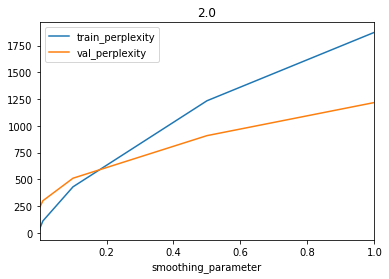

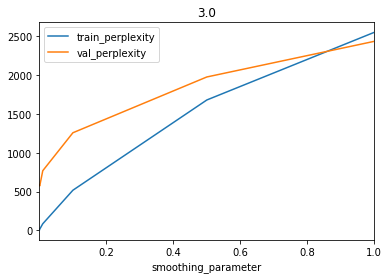

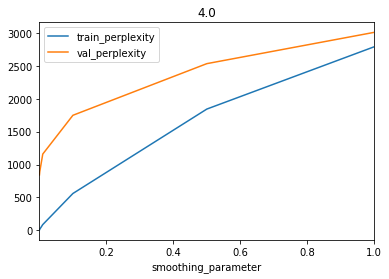

In [97]:
for title, group in pd.concat([ngram_tune_results['params'].apply(pd.Series), ngram_tune_results.drop(['params'], axis=1)], axis=1).\
  groupby(by='n')[['smoothing_parameter', 'train_perplexity', 'val_perplexity']]:
    group.drop(labels=['n'], axis=1).plot(x='smoothing_parameter', title=title)

In [124]:
pd.concat([ngram_tune_results['params'].apply(pd.Series), ngram_tune_results.drop(['params'], axis=1)], axis=1)

,n,smoothing_parameter,train_perplexity,val_perplexity,raw_generated_text
0,2.0,0.0001,27.812,298.218,<s> сокровенный <s> и есть мы <UNK> <s> и тень...
1,2.0,0.0010,44.1861,241.98,<s> которой вправо стреле любил и коль небесах...
2,2.0,0.0100,112.324,301.21,<s> благотворен вылетая бич бесконечным чужда ...
3,2.0,0.1000,431.236,511.686,<s> столького злится земные бурый горести вопи...
4,2.0,0.5000,1234.83,909.179,<s> произнесу бросился доверяет жизни невоздел...
5,2.0,1.0000,1873.89,1218.44,<s> мирные заточенный ухватил кстати претерпев...
6,3.0,0.0001,6.18886,582.691,<s> <s> а длиннее ветрила круглом смутился вил...
7,3.0,0.0010,17.6375,574.783,<s> <s> помысел наставлял подбровной яви начал...
8,3.0,0.0100,86.4392,769.207,<s> <s> рим пройденного треснул затих мастера ...
9,3.0,0.1000,518.179,1257.85,<s> <s> ушко низина темной вздымая явить днем ...


For 3-gram and greater perplexity on val is pretty always bigger than on train. It tells us that the model overfits on train sentences because there are not many of them.  
Thus I chose the params with which the model doesn't overfit much on train and has small perplexity on val set at the same time. Also for bigram model with smallest smoothing params we can see that generated text is splitted on lines as it expected

### Launch final n-gram model

In [0]:
def launch_ngram(n, smoothing_parameter, fixed_vocab, train_sentences, val_sentences, 
                 gen_text_length=100, process_generated_text=False, plot_perplexities=True):
    
    logging.info('Creating {}-gram model with smoothing_parameter {}'.format(n, smoothing_parameter))
    model = NgramModel(n=n, smoothing_parameter=smoothing_parameter, fixed_vocab=fixed_vocab)

    logging.info('Training {}-gram model'.format(n))
    model.update_occurances(train_sentences)
    model.update_probs()
    
    logging.info('Generating text with len={}'.format(gen_text_length))
    generated_text = model.random_text(gen_text_length)
    if process_generated_text:
        generated_text = re.sub(r'<UNK>', '', generated_text)
        print('generated text:\n', re.sub(r'(<s> ){1,}', '\n', generated_text))
    else:
        print('generated_text\n', generated_text)
    
    logging.info('Calculating perplexity for train')
    train_perplexity = perplexity(train_sentences, model)
    print('train_perplexity: {}'.format(train_perplexity))
    
    logging.info('Calculating perplexity for val')
    val_perplexity = perplexity(val_sentences, model)
    print('val_perplexity: {}'.format(val_perplexity))
    
    return model, generated_text, train_perplexity, val_perplexity

In [122]:
%%time

ngram_model, ngram_generated_text, ngram_train_perplexities_df, ngram_val_perplexities_df = launch_ngram(
    n=2,
    smoothing_parameter=0.001,
    fixed_vocab=vocab,
    train_sentences=train_sentences,
    val_sentences=val_sentences,
    gen_text_length=100,
    process_generated_text=True)

INFO      [2019-11-02 15:52:01,575] : Creating 2-gram model with smoothing_parameter 0.001
INFO      [2019-11-02 15:52:01,577] : Training 2-gram model
INFO      [2019-11-02 15:52:07,841] : Generating text with len=100
generated text:
 
хотя и вот как  явился обращен изрядно стоя рядом крутоскатый жертва ловчими отрицая 
стал добра 
украшен путь адский воет глубина ланфранки вечных блеснет заря возраставший круче насколько средину соблюдая 
потом более должен плюет знойными посул неутомимо оставшись доблестные воедино народ преград строившему медлю пришло разгадку прежнее село 
распаленный часть дороги сила нами истинный коците чахнет но могло подвал готова задними своею рено долгий срок ему исполнившие прокаженный почтите высочайшего рад весело отплыл милей бойтесь настанет утонул пыткою цепей жаль конца пресекши горя дав почтил огонька твердынях наружный знакомой возвратил мечешь сызнова оплот жаждал увязшим сядет <s>
INFO      [2019-11-02 15:52:08,879] : Calculating perplexity for tr

100%|██████████| 57386/57386 [00:00<00:00, 158132.44it/s]

train_perplexity: 44.18606038060549
INFO      [2019-11-02 15:52:11,399] : Calculating perplexity for val



100%|██████████| 18847/18847 [00:00<00:00, 149686.52it/s]

val_perplexity: 241.979766807647
CPU times: user 10.8 s, sys: 93.5 ms, total: 10.9 s
Wall time: 10.9 s


In [125]:
print('generated text:\n', re.sub(r'(<s> ){1,}', '\n', re.sub(r'<UNK>', '', ngram_generated_text)))

generated text:
 
хотя и вот как  явился обращен изрядно стоя рядом крутоскатый жертва ловчими отрицая 
стал добра 
украшен путь адский воет глубина ланфранки вечных блеснет заря возраставший круче насколько средину соблюдая 
потом более должен плюет знойными посул неутомимо оставшись доблестные воедино народ преград строившему медлю пришло разгадку прежнее село 
распаленный часть дороги сила нами истинный коците чахнет но могло подвал готова задними своею рено долгий срок ему исполнившие прокаженный почтите высочайшего рад весело отплыл милей бойтесь настанет утонул пыткою цепей жаль конца пресекши горя дав почтил огонька твердынях наружный знакомой возвратил мечешь сызнова оплот жаждал увязшим сядет <s>


In [128]:
ngram_test_perplexity = perplexity(test_sentences, ngram_model)
print('test_perplexity: {}'.format(ngram_test_perplexity))

100%|██████████| 18753/18753 [00:00<00:00, 144406.27it/s]

test_perplexity: 234.4412192711576


## Neural language model

### Define neural language model

In [0]:
class NeuralLM():
    def __init__(self,
                 window_size=2,
                 emb_dim=50,
                 epochs=100,
                 left_pad_symbol='<s>',
                 right_pad_symbol='</s>',
                 fixed_vocab=None,
                 use_TPU=False):

        self.emb_dim = emb_dim
        self.epochs = epochs
        self.window = window_size
        # ngram interpretation for calculating perplexity
        self.n = self.window + 1

        self.left_pad_symbol = left_pad_symbol
        #self.right_pad_symbol = right_pad_symbol
        self.fixed_vocab = fixed_vocab + [left_pad_symbol]

        self.use_TPU = use_TPU


    def generate_tf_vectors_and_target(self, sequence_of_tokens):

        # create ngrams of defined length
        ngrams = zip(*[sequence_of_tokens[i:] for i in range(self.n)])
        
        contexts = []
        targets = []
        for ngram in ngrams:
            context = [self.word2index(word) for word in ngram[:-1]]
            contexts.append(context)
            
            target = self.word2onehot(ngram[-1])
            targets.append(target)

        targets, contexts = np.array(targets), np.array(contexts)
        return targets, contexts

    def generate_training_data(self, train_corpus_global, val_corpus_global=None):

        train_corpus = copy(train_corpus_global)
      
        sequence_of_train_tokens = corpus2seq(train_corpus, self.left_pad_symbol, self.n, self.fixed_vocab)

        # Find unique word counts using dictonary
        word_counts = defaultdict(int)
        for word in sequence_of_train_tokens:
            word_counts[word] += 1
        

        ## How many unique words in vocab?
        self.v_count = len(word_counts.keys())
        # Generate Lookup Dictionaries (vocab)
        self.words_list = list(word_counts.keys())
        # Generate word:index
        self.word_index = dict(
            (word, i) for i, word in enumerate(self.words_list))
        # Generate index:word
        self.index_word = dict(
            (i, word) for i, word in enumerate(self.words_list))

        
        train_target, train_context = self.generate_tf_vectors_and_target(
            sequence_of_train_tokens)

        if val_corpus_global is not None:
            val_corpus = copy(val_corpus_global)
            sequence_of_val_tokens = corpus2seq(val_corpus, self.left_pad_symbol, self.n, self.fixed_vocab)         
            val_target, val_context = self.generate_tf_vectors_and_target(
                    sequence_of_val_tokens)

            return train_target, train_context, val_target, val_context
        else:
            return train_target, train_context

    def word2onehot(self, word):
        # word_vec - initialise a blank vector
        word_vec = [0 for i in range(0, self.v_count)
                    ]  # Alternative - np.zeros(self.v_count)
        # Get ID of word from word_index
        word_index = self.word_index[word]
        # Change value from 0 to 1 according to ID of the word
        word_vec[word_index] = 1
        return word_vec

    def word2index(self, word):
        # word_vec - initialise a blank vector
        word_vec = [0 for i in range(0, self.v_count)
                    ]  # Alternative - np.zeros(self.v_count)
        # Get ID of word from word_index
        word_index = self.word_index[word]
        return word_index

    def index2word(self, index):
        return self.index_word[index]

    def define_model(self, ):
        keras.backend.clear_session()

        model = Sequential()
        model.add(
            Embedding(input_dim=self.v_count,
                      output_dim=self.emb_dim,
                      input_length=self.window))
        model.add(Flatten())
        model.add(Dense(units=self.v_count, activation=softmax))

        logging.info('Compiling model')
        model.compile(optimizer=keras.optimizers.Adam(),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

        if self.use_TPU:
          model = tf.contrib.tpu.keras_to_tpu_model(model,
              strategy=tf.contrib.tpu.TPUDistributionStrategy(
                  tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS)))

        self.model = model

    def prob(self, word, context):

        context_indices = [self.word2index(word) for word in context]
        predicted_probs = self.model.predict_proba(np.array([context_indices]))

        word_index = self.word2index(word)
        return predicted_probs[0][word_index]

    def random_word_from_context(self, context):
        ''' Returns a random word based on the given context '''

        context_indices = [self.word2index(word) for word in context]
        predicted_probs = self.model.predict_proba(np.array([context_indices
                                                             ]))[0]

        # probability_distribution = np.array(list(probability_distribution))
        # probability_distribution /= probability_distribution.sum()
        #print('probability_distribution:{}'.format(probability_distribution))
        # print('self words list', self.words_list[:10], len(self.words_list))
        # print('predicted_probs', predicted_probs.shape)
        return np.random.choice(self.words_list, p=predicted_probs)

    def random_text(self, length):
        ''' Returns text of the specified character length '''

        text_beginning = list(repeat(self.left_pad_symbol, self.window))
        text = " ".join(list(text_beginning))

        for i in range(length):
            # next context contain last n-1 words
            context = text.split(' ')[-1 * self.window:]
            #print('context', context, type(context))
            word = self.random_word_from_context(context)
            text = ' '.join([text, word])

        return ' '.join([text, self.left_pad_symbol])

In [0]:
class PerplexityEarlyStopping(Callback):
    """Callback for early stopping based on perplexity on the validation set
  """
    def __init__(self, validation_data, patience=0):
        super().__init__()
        self.contexts, self.targets = validation_data
        self.best = np.Inf
        self.patience = patience
        self.current_patience = patience

    def on_epoch_end(self, epoch, logs=None):
        pred = self.model.predict(self.contexts)
        log2_probs = [
            np.log2(pred[i, target[0]])
            for i, target in enumerate(self.targets)
        ]
        perp = 2**(-sum(log2_probs) / self.targets.shape[0])
        print(' - perplexity: {}'.format(perp))
        if np.less(perp, self.best):
            self.best = perp
            self.current_patience = self.patience
        else:
            self.current_patience -= 1
            if self.current_patience < 0:
              self.model.stop_training = True
              print('Early stopping due to higher perplexity')
              self.current_patience = self.patience
            else:
              print('{} patience remained'.format(self.current_patience))

### Tune neural language model

In [0]:
def tune_neural(params_to_tune, fixed_vocab, train_sentences, val_sentences,
                gen_text_length=100, process_generated_text=False):

    grid_list = list(ParameterGrid(params_to_tune))
    
    results = pd.DataFrame(columns=['params',
                                    'train_perplexity',
                                    'val_perplexity',
                                    'raw_generated_text'])
    
    for param_set in tqdm(grid_list, total=len(grid_list)):
        logging.info('Current params set:{}'.format(param_set))
        
        neural_model = NeuralLM(window_size=param_set['window_size'],
                            emb_dim=param_set['emb_dim'],
                            epochs=150,
                            fixed_vocab=vocab,
                            use_TPU=False)

        logging.info('Preparing data for neural model')
        train_target, train_context, val_target, val_context = neural_model.generate_training_data(train_corpus_global=train_sentences, 
                                                              val_corpus_global=val_sentences)

        logging.info('Building keras model')
        neural_model.define_model()

        # form callbacks list
        PerplexityES = PerplexityEarlyStopping(validation_data=(val_context, val_target), 
                                              patience=1)
        # save_best = ModelCheckpoint('nn_weights-{epoch:03d}-{acc:03f}-{val_acc:03f}.hdf5', save_best_only=True, 
        #                            monitor='categorical_crossentropy', mode='min')

        logging.info('Train neural model')
        # fit the model
        neural_model.model.fit(
            x=train_context,
            y=train_target,
            validation_data=(val_context, val_target),
            epochs=neural_model.epochs,
            verbose=0,
            batch_size=param_set['batch_size'],
            callbacks=[PerplexityES,
                      #save_best
                      ])
        # evaluate the model
        # loss, accuracy = neural_model.model.evaluate(context, target, verbose=0)
        # print('Accuracy: %f' % (accuracy))
        
        generated_text = neural_model.random_text(gen_text_length)
        if process_generated_text:
            generated_text = re.sub(r'<UNK>', '', generated_text)
            print('generated text:\n', re.sub(r'[ <s>]{1,}', '\n', generated_text))
        else:
            print('generated_text\n', generated_text)
        
        logging.info('Calculating perplexity for train')
        train_perplexity = perplexity(train_sentences, neural_model)
        print('train_perplexity: {}'.format(train_perplexity))
        
        logging.info('Calculating perplexity for val')
        val_perplexity = perplexity(val_sentences, neural_model)
        print('val_perplexity: {}'.format(val_perplexity))
    
        results.loc[len(results), results.columns] = {'emb_dim': param_set['emb_dim'], 
                                                      'window_size': param_set['window_size'], 
                                                      'batch_size': param_set['batch_size']}, \
                                                      train_perplexity, \
                                                      val_perplexity, \
                                                      generated_text
        
        logging.info('Current results\n{}'.format(results[results.columns[:-1]]))
        
        
    return results

In [100]:
%%time

params_to_tune = {
    'emb_dim': [200],
    'window_size': list(range(2,9)),
    'batch_size': [256]
}

neural_tune_results = tune_neural(params_to_tune=params_to_tune, fixed_vocab=vocab, 
                                  train_sentences=train_sentences, 
                                  val_sentences=val_sentences,
                                  process_generated_text=False)

  0%|          | 0/7 [00:00<?, ?it/s]

INFO      [2019-11-02 10:03:36,422] : Current params set:{'batch_size': 256, 'emb_dim': 200, 'window_size': 2}
INFO      [2019-11-02 10:03:36,423] : Preparing data for neural model
INFO      [2019-11-02 10:08:31,500] : Building keras model
INFO      [2019-11-02 10:08:31,548] : Compiling model
INFO      [2019-11-02 10:08:31,599] : Train neural model
 - perplexity: 136.8889505155377
 - perplexity: 285.3043581720392
0 patience remained
 - perplexity: 630.4175774243124
Early stopping due to higher perplexity
generated_text
 <s> <s> кто простимся смоль шагая ново <s> а сказал вольна было <s> <s> в милей среди ей <s> <s> а нас <UNK> с и был мне бык я настолько толпу <s> <s> я начал старался мы воздух <UNK> <s> <s> тот свой хулой надорвет <s> <s> уже вниз как в строго <s> <s> сестра так как том <s> <s> я волосы пропасти восседает <s> <s> и головой <s> <s> за стал <s> <s> моей но сказав обратился грани <s> <s> и него слов <s> <s> как вдруг <s> <s> не <UNK> ни трижды милый не моста не <UNK> <s>


100%|██████████| 65929/65929 [05:50<00:00, 188.14it/s]

train_perplexity: 133.30073907683797
INFO      [2019-11-02 10:15:09,359] : Calculating perplexity for val



100%|██████████| 21695/21695 [01:55<00:00, 187.64it/s]

val_perplexity: 85.12017199802112
INFO      [2019-11-02 10:17:06,222] : Current results
                                              params  ... val_perplexity
0  {'emb_dim': 200, 'window_size': 2, 'batch_size...  ...        85.1202

[1 rows x 3 columns]


 14%|█▍        | 1/7 [13:29<1:20:58, 809.80s/it]

INFO      [2019-11-02 10:17:06,224] : Current params set:{'batch_size': 256, 'emb_dim': 200, 'window_size': 3}
INFO      [2019-11-02 10:17:06,227] : Preparing data for neural model
INFO      [2019-11-02 10:22:28,541] : Building keras model
INFO      [2019-11-02 10:22:28,583] : Compiling model
INFO      [2019-11-02 10:22:28,644] : Train neural model
 - perplexity: 373.6772619087189
 - perplexity: 1563.3233023131775
0 patience remained
 - perplexity: 4008.696664174954
Early stopping due to higher perplexity
generated_text
 <s> <s> <s> уж нам там где все этом <s> <s> <s> своим и учитель <s> <s> над когда из цели устремлен <s> <s> <s> так каталано злосчастный придите вас судно <s> <s> <s> толпы другим меж <UNK> <UNK> будто <UNK> <s> <s> <s> теней ко мало <s> <s> <s> увидели пастей сердце истребились говорю за пронзен <UNK> нет в некогда вашем отец мире всех расстались недлинен взгляд <s> <s> <s> зачатый разгром отринул хребта вождь в преисподней порок <s> <s> <s> и <UNK> <UNK> <UNK> <s> <s


100%|██████████| 74472/74472 [08:51<00:00, 140.14it/s]

train_perplexity: 61.512578491038745
INFO      [2019-11-02 10:32:18,897] : Calculating perplexity for val



100%|██████████| 24543/24543 [02:44<00:00, 149.27it/s]

val_perplexity: 49.07311896126772
INFO      [2019-11-02 10:35:04,823] : Current results
                                              params  ... val_perplexity
0  {'emb_dim': 200, 'window_size': 2, 'batch_size...  ...        85.1202
1  {'emb_dim': 200, 'window_size': 3, 'batch_size...  ...        49.0731

[2 rows x 3 columns]


 29%|██▊       | 2/7 [31:28<1:14:12, 890.44s/it]

INFO      [2019-11-02 10:35:04,825] : Current params set:{'batch_size': 256, 'emb_dim': 200, 'window_size': 4}
INFO      [2019-11-02 10:35:04,829] : Preparing data for neural model
INFO      [2019-11-02 10:42:35,296] : Building keras model
INFO      [2019-11-02 10:42:35,347] : Compiling model
INFO      [2019-11-02 10:42:35,408] : Train neural model
 - perplexity: 1218.696718267945
 - perplexity: 4978.827695582172
0 patience remained
 - perplexity: 10165.20215727323
Early stopping due to higher perplexity
generated_text
 <s> <s> <s> <s> и дальний вероломству кто людском давал <s> <s> <s> <s> то что церкви сгори бичевавший оболочкой гневливо ему ей я себе была <s> <s> <s> <s> и с дух <UNK> <s> <s> <s> <s> как брели огонь тебе подыматься строй <s> <s> <s> <s> чтобы иных из беседы <s> <s> <s> <s> о дай и мысль <s> <s> <s> <s> так же б в ответ приведен <s> <s> <s> <s> знай я только первом укрылся срок <s> <s> <s> <s> когда господня может <UNK> спутник <s> <s> <s> <s> и правда лицо и ее <UNK


100%|██████████| 83015/83015 [12:50<00:00, 107.78it/s]

train_perplexity: 34.179857936135
INFO      [2019-11-02 10:56:40,014] : Calculating perplexity for val



100%|██████████| 27391/27391 [04:14<00:00, 107.84it/s]

val_perplexity: 31.95887094366244
INFO      [2019-11-02 11:00:55,820] : Current results
                                              params  ... val_perplexity
0  {'emb_dim': 200, 'window_size': 2, 'batch_size...  ...        85.1202
1  {'emb_dim': 200, 'window_size': 3, 'batch_size...  ...        49.0731
2  {'emb_dim': 200, 'window_size': 4, 'batch_size...  ...        31.9589

[3 rows x 3 columns]


 43%|████▎     | 3/7 [57:19<1:12:34, 1088.61s/it]

INFO      [2019-11-02 11:00:55,822] : Current params set:{'batch_size': 256, 'emb_dim': 200, 'window_size': 5}
INFO      [2019-11-02 11:00:55,824] : Preparing data for neural model
INFO      [2019-11-02 11:08:42,632] : Building keras model
INFO      [2019-11-02 11:08:42,678] : Compiling model
INFO      [2019-11-02 11:08:42,747] : Train neural model
 - perplexity: 5997.735188347548
 - perplexity: 10236.461259708132
0 patience remained
 - perplexity: 20590.030761215872
Early stopping due to higher perplexity
generated_text
 <s> <s> <s> <s> <s> с небес ждал ныне <s> <s> <s> <s> <s> не смерть но глаза почве <s> <s> <s> <s> <s> тогда чьи самый что чакко остальным он <UNK> <s> <s> <s> <s> <s> что <UNK> в час вас <s> <s> <s> <s> <s> нельзя обессиленному их входит речь <s> <s> <s> <s> <s> он в клокотаньи волной мне <s> <s> <s> <s> <s> кто мой вождь причину и нами мой <s> <s> <s> <s> <s> <UNK> <UNK> слог <UNK> <s> <s> <s> <s> <s> духи молвил я спуск в грешить там где берлог <s> <s> <s> <s> <s> 


100%|██████████| 91558/91558 [14:47<00:00, 103.14it/s]

train_perplexity: 21.85117401460979
INFO      [2019-11-02 11:25:01,392] : Calculating perplexity for val



100%|██████████| 30239/30239 [04:55<00:00, 102.22it/s]

val_perplexity: 22.394185864703406
INFO      [2019-11-02 11:29:59,312] : Current results
                                              params  ... val_perplexity
0  {'emb_dim': 200, 'window_size': 2, 'batch_size...  ...        85.1202
1  {'emb_dim': 200, 'window_size': 3, 'batch_size...  ...        49.0731
2  {'emb_dim': 200, 'window_size': 4, 'batch_size...  ...        31.9589
3  {'emb_dim': 200, 'window_size': 5, 'batch_size...  ...        22.3942

[4 rows x 3 columns]


 57%|█████▋    | 4/7 [1:26:22<1:04:15, 1285.07s/it]

INFO      [2019-11-02 11:29:59,314] : Current params set:{'batch_size': 256, 'emb_dim': 200, 'window_size': 6}
INFO      [2019-11-02 11:29:59,316] : Preparing data for neural model
INFO      [2019-11-02 11:39:36,703] : Building keras model
INFO      [2019-11-02 11:39:36,746] : Compiling model
INFO      [2019-11-02 11:39:36,823] : Train neural model
 - perplexity: 4730.559707046898
 - perplexity: 11555.943011989266
0 patience remained
 - perplexity: 25495.962389914537
Early stopping due to higher perplexity
generated_text
 <s> <s> <s> <s> <s> <s> во я муз и этой ним ангелов налет <s> <s> <s> <s> <s> навис не победы побледнев земле <s> <s> <s> <s> <s> <s> а телом из <UNK> не <UNK> <s> <s> <s> <s> <s> <s> ища хранитель издал вечному берега прохладце неодолим <s> <s> <s> <s> гвидо поспешней людской полезным ответ в них чреду полдневный мантуанца понурил <s> <s> <s> <s> быть вид жена следил <s> <s> <s> <s> <s> <s> иль укрыл от крови ними <s> <s> <s> <s> <s> <s> места чтобы ряд я начал в <s>


100%|██████████| 100101/100101 [18:29<00:00, 90.18it/s]

train_perplexity: 15.108587276957262
INFO      [2019-11-02 11:59:54,337] : Calculating perplexity for val



100%|██████████| 33087/33087 [06:02<00:00, 91.21it/s]

val_perplexity: 16.805316086302927
INFO      [2019-11-02 12:05:59,444] : Current results
                                              params  ... val_perplexity
0  {'emb_dim': 200, 'window_size': 2, 'batch_size...  ...        85.1202
1  {'emb_dim': 200, 'window_size': 3, 'batch_size...  ...        49.0731
2  {'emb_dim': 200, 'window_size': 4, 'batch_size...  ...        31.9589
3  {'emb_dim': 200, 'window_size': 5, 'batch_size...  ...        22.3942
4  {'emb_dim': 200, 'window_size': 6, 'batch_size...  ...        16.8053

[5 rows x 3 columns]


 71%|███████▏  | 5/7 [2:02:23<51:35, 1547.59s/it]  

INFO      [2019-11-02 12:05:59,445] : Current params set:{'batch_size': 256, 'emb_dim': 200, 'window_size': 7}
INFO      [2019-11-02 12:05:59,448] : Preparing data for neural model
INFO      [2019-11-02 12:21:23,421] : Building keras model
INFO      [2019-11-02 12:21:23,465] : Compiling model
INFO      [2019-11-02 12:21:23,548] : Train neural model
 - perplexity: 7474.9575896350025
 - perplexity: 24131.516611691386
0 patience remained
 - perplexity: 79389.92700873027
Early stopping due to higher perplexity
generated_text
 <s> <s> <s> <s> <s> <s> <s> взгляни так <UNK> посередине его <s> <s> <s> <s> <s> <s> <s> а забрале <UNK> правды ему <s> <s> <s> <s> <s> <s> <s> я был тебе бонифаций как бы <UNK> <s> <s> <s> <s> <s> <s> <s> и кругом дивился и в ухо сойдя род <s> <s> <s> <s> <s> <s> <s> был все же затылок и моим <s> <s> <s> <s> <s> <s> <s> сказав и я привык или тебя <s> <s> <s> <s> <s> <s> <s> пусть чувствовал <UNK> красоту <s> <s> <s> <s> <s> <s> <s> двух риньер мне речь сторону стаций


100%|██████████| 108644/108644 [22:25<00:00, 80.76it/s]

train_perplexity: 11.290163517603474
INFO      [2019-11-02 12:45:59,022] : Calculating perplexity for val



100%|██████████| 35935/35935 [07:21<00:00, 81.45it/s]

val_perplexity: 13.417675067750912
INFO      [2019-11-02 12:53:22,837] : Current results
                                              params  ... val_perplexity
0  {'emb_dim': 200, 'window_size': 2, 'batch_size...  ...        85.1202
1  {'emb_dim': 200, 'window_size': 3, 'batch_size...  ...        49.0731
2  {'emb_dim': 200, 'window_size': 4, 'batch_size...  ...        31.9589
3  {'emb_dim': 200, 'window_size': 5, 'batch_size...  ...        22.3942
4  {'emb_dim': 200, 'window_size': 6, 'batch_size...  ...        16.8053
5  {'emb_dim': 200, 'window_size': 7, 'batch_size...  ...        13.4177

[6 rows x 3 columns]


 86%|████████▌ | 6/7 [2:49:46<32:16, 1936.33s/it]

INFO      [2019-11-02 12:53:22,839] : Current params set:{'batch_size': 256, 'emb_dim': 200, 'window_size': 8}
INFO      [2019-11-02 12:53:22,841] : Preparing data for neural model
INFO      [2019-11-02 13:09:00,029] : Building keras model
INFO      [2019-11-02 13:09:00,079] : Compiling model
INFO      [2019-11-02 13:09:00,255] : Train neural model
 - perplexity: 16987.097167488053
 - perplexity: 53248.11760310931
0 patience remained
 - perplexity: 221446.54126859858
Early stopping due to higher perplexity
generated_text
 <s> <s> <s> <s> <s> <s> <s> <s> воскликнули и впереди <UNK> <s> <s> <s> <s> <s> <s> <s> <s> чудесное похвально лишь мраке едва душой <s> <s> <s> <s> <s> <s> <s> <s> <UNK> в утробе ждет <s> <s> <s> <s> <s> <s> <s> <s> тела я к вышине добрых стал слава <s> <s> <s> <s> <s> <s> <s> <s> он горло сюда первый к песнью рожденный <s> <s> <s> <s> <s> <s> <s> <s> плоско один слетел но хладная это <s> <s> <s> <s> <s> <s> <s> <s> какая украшен мы разбойники идти вид <s> <s> <s> <s


100%|██████████| 117187/117187 [25:58<00:00, 75.20it/s]

train_perplexity: 8.824912730648009
INFO      [2019-11-02 13:37:25,255] : Calculating perplexity for val



100%|██████████| 38783/38783 [08:40<00:00, 74.53it/s]

val_perplexity: 11.010919594073792
INFO      [2019-11-02 13:46:08,526] : Current results
                                              params  ... val_perplexity
0  {'emb_dim': 200, 'window_size': 2, 'batch_size...  ...        85.1202
1  {'emb_dim': 200, 'window_size': 3, 'batch_size...  ...        49.0731
2  {'emb_dim': 200, 'window_size': 4, 'batch_size...  ...        31.9589
3  {'emb_dim': 200, 'window_size': 5, 'batch_size...  ...        22.3942
4  {'emb_dim': 200, 'window_size': 6, 'batch_size...  ...        16.8053
5  {'emb_dim': 200, 'window_size': 7, 'batch_size...  ...        13.4177
6  {'emb_dim': 200, 'window_size': 8, 'batch_size...  ...        11.0109

[7 rows x 3 columns]


100%|██████████| 7/7 [3:42:32<00:00, 2305.14s/it]

CPU times: user 5h 57min 17s, sys: 36min 40s, total: 6h 33min 57s
Wall time: 3h 42min 32s


In [101]:
pd.concat([neural_tune_results['params'].apply(pd.Series), neural_tune_results.drop(['params'], axis=1)], axis=1)

,emb_dim,window_size,batch_size,train_perplexity,val_perplexity,raw_generated_text
0,200,2,256,133.301,85.1202,<s> <s> кто простимся смоль шагая ново <s> а с...
1,200,3,256,61.5126,49.0731,<s> <s> <s> уж нам там где все этом <s> <s> <s...
2,200,4,256,34.1799,31.9589,<s> <s> <s> <s> и дальний вероломству кто людс...
3,200,5,256,21.8512,22.3942,<s> <s> <s> <s> <s> с небес ждал ныне <s> <s> ...
4,200,6,256,15.1086,16.8053,<s> <s> <s> <s> <s> <s> во я муз и этой ним ан...
5,200,7,256,11.2902,13.4177,<s> <s> <s> <s> <s> <s> <s> взгляни так <UNK> ...
6,200,8,256,8.82491,11.0109,<s> <s> <s> <s> <s> <s> <s> <s> воскликнули и ...


All models have very big perplexity on val but relatively small on train. Presumably the problem lies in the small volume of train dataset for such complex model. So I will take the model with highest accuracy

### Launch final neural language model

In [0]:
def launch_NeuralLM(window_size,
                    emb_dim,
                    epochs,
                    es_patience, 
                    batch_size,
                    train_sentences,
                    val_sentences,
                    fixed_vocab=vocab,
                    gen_text_length=100,
                    plot_perplexities=True,
                    process_generated_text=False,
                    use_TPU=False):

    logging.info('Creating model with window_size={}'.format(window_size))

    neural_model = NeuralLM(window_size=window_size,
                            emb_dim=emb_dim,
                            epochs=epochs,
                            fixed_vocab=vocab,
                            use_TPU=use_TPU)

    logging.info('Preparing data for neural model')
    train_target, train_context, val_target, val_context = neural_model.generate_training_data(train_corpus_global=train_sentences, 
                                                          val_corpus_global=val_sentences)

    logging.info('Building keras model')
    neural_model.define_model()
    neural_model.model.summary()

    # form callbacks list
    PerplexityES = PerplexityEarlyStopping(validation_data=(val_context, val_target), 
                                           patience=es_patience)
    # save_best = ModelCheckpoint('nn_weights-{epoch:03d}-{acc:03f}-{val_acc:03f}.hdf5', save_best_only=True, 
    #                            monitor='categorical_crossentropy', mode='min')

    logging.info('Train neural model')
    # fit the model
    neural_model.model.fit(
        x=train_context,
        y=train_target,
        validation_data=(val_context, val_target),
        epochs=neural_model.epochs,
        verbose=2,
        batch_size=batch_size,
        callbacks=[PerplexityES,
                   #save_best
                   ])

    # evaluate the model
    # loss, accuracy = neural_model.model.evaluate(context, target, verbose=0)
    # print('Accuracy: %f' % (accuracy))

    logging.info('Generating text with len={}'.format(gen_text_length))
    generated_text = neural_model.random_text(gen_text_length)
    if process_generated_text:
        generated_text = re.sub(r'<UNK>', '', generated_text)
        print('generated text:\n', re.sub(r'[<s>]{1,}', '\n', generated_text))
    else:
        print('generated_text\n', generated_text)

    logging.info('Calculating perplexity for train')
    train_perplexity = perplexity(train_sentences, neural_model)
    print('train_perplexity: {}'.format(train_perplexity))
    
    logging.info('Calculating perplexity for val')
    val_perplexity = perplexity(val_sentences, neural_model)
    print('val_perplexity: {}'.format(val_perplexity))
    
    return neural_model, generated_text, train_perplexity, val_perplexity

In [103]:
%%time

neural_model, neural_model_generated_text, neural_train_perplexity, neural_val_perplexity = launch_NeuralLM(
    window_size=8,
    emb_dim=200,
    epochs=150,
    es_patience=1,
    batch_size=256,
    fixed_vocab=vocab,
    train_sentences=train_sentences,
    val_sentences=val_sentences,
    gen_text_length=1000,
    plot_perplexities=True,
    process_generated_text=False,
    use_TPU=False)

INFO      [2019-11-02 14:33:42,140] : Creating model with window_size=8
INFO      [2019-11-02 14:33:42,144] : Preparing data for neural model
INFO      [2019-11-02 14:53:42,956] : Building keras model
INFO      [2019-11-02 14:53:43,048] : Compiling model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 200)            2000400   
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10002)             16013202  
Total params: 18,013,602
Trainable params: 18,013,602
Non-trainable params: 0
_________________________________________________________________
INFO      [2019-11-02 14:53:43,102] : Train neural model
Train on 117187 samples, validate on 38783 samples
Epoch 1/150

100%|██████████| 117187/117187 [26:47<00:00, 72.89it/s]

train_perplexity: 8.844940048361282
INFO      [2019-11-02 15:23:25,964] : Calculating perplexity for val



100%|██████████| 38783/38783 [08:50<00:00, 73.14it/s]

val_perplexity: 10.99904416509376
CPU times: user 1h 34min 36s, sys: 13min 14s, total: 1h 47min 51s
Wall time: 58min 37s


In [120]:
print('generated text:\n', re.sub(r'(<s> ){1,}', '\n', re.sub(r'<UNK>', '', neural_model_generated_text)))

generated text:
 
мои божья меня и дышишь вновь сеть 
поток одинокий так темных в вы мне 
там где повел от  была 
родины  нее 
 
изгнаны 
мне же за украсив отвернись беды 
зерно 
бедра отрадный дан умастясь 
корчится дочитал мой слыша втайне ты взору мраморной 
спасла в чем защита ясность дал сенью 
отсеченного когда б твердь счастлив всемогущий 
не  чтоб тот кому отринул 
с ним глазам постой бывало 
коснел святые по меня из блеснуть 
вот шьют на него обе носит 
как  тем есть очищенья своего 
и тесть я гибну отчетливей 
низ 
тропа рассказ плоды перед руки земли 
мы были моим предо страшно 
рухнул так что ты бы слезой  
а ты невылазной пустыней 
топили твой если  медленно 
нашей вождь крайний был запечатлей как у ночью 
и я корнем принес обжигаю и стеной 
тогда зрел муж чтоб это свет там 
слезами спутником  может наконец 
скрутив для возле и взгляд мужем вопли чудно 
стараясь я бы нам нам удел 
боязнь слугами что разуму челюсть от наших возврата 
там дадим когда у нужно боязнь  
in прок

In [129]:
neural_test_perplexity = perplexity(test_sentences, neural_model)
print('test_perplexity: {}'.format(neural_test_perplexity))

100%|██████████| 38689/38689 [08:47<00:00, 73.38it/s]

test_perplexity: 10.891189362949257


# Results comparing

In [141]:
pd.set_option('display.max_colwidth', -1)
both_model_results = pd.concat([ngram_tune_results, neural_tune_results], axis=0)
both_model_results.sort_values(by=['val_perplexity'])

,params,train_perplexity,val_perplexity,raw_generated_text
6,"{'emb_dim': 200, 'window_size': 8, 'batch_size': 256}",8.82491,11.0109,<s> <s> <s> <s> <s> <s> <s> <s> воскликнули и впереди <UNK> <s> <s> <s> <s> <s> <s> <s> <s> чудесное похвально лишь мраке едва душой <s> <s> <s> <s> <s> <s> <s> <s> <UNK> в утробе ждет <s> <s> <s> <s> <s> <s> <s> <s> тела я к вышине добрых стал слава <s> <s> <s> <s> <s> <s> <s> <s> он горло сюда первый к песнью рожденный <s> <s> <s> <s> <s> <s> <s> <s> плоско один слетел но хладная это <s> <s> <s> <s> <s> <s> <s> <s> какая украшен мы разбойники идти вид <s> <s> <s> <s> <s> <s> <s> <s> лучом душе влево над <s>
5,"{'emb_dim': 200, 'window_size': 7, 'batch_size': 256}",11.2902,13.4177,<s> <s> <s> <s> <s> <s> <s> взгляни так <UNK> посередине его <s> <s> <s> <s> <s> <s> <s> а забрале <UNK> правды ему <s> <s> <s> <s> <s> <s> <s> я был тебе бонифаций как бы <UNK> <s> <s> <s> <s> <s> <s> <s> и кругом дивился и в ухо сойдя род <s> <s> <s> <s> <s> <s> <s> был все же затылок и моим <s> <s> <s> <s> <s> <s> <s> сказав и я привык или тебя <s> <s> <s> <s> <s> <s> <s> пусть чувствовал <UNK> красоту <s> <s> <s> <s> <s> <s> <s> двух риньер мне речь сторону стаций <UNK> <s> <s> <s> <s>
4,"{'emb_dim': 200, 'window_size': 6, 'batch_size': 256}",15.1086,16.8053,<s> <s> <s> <s> <s> <s> во я муз и этой ним ангелов налет <s> <s> <s> <s> <s> навис не победы побледнев земле <s> <s> <s> <s> <s> <s> а телом из <UNK> не <UNK> <s> <s> <s> <s> <s> <s> ища хранитель издал вечному берега прохладце неодолим <s> <s> <s> <s> гвидо поспешней людской полезным ответ в них чреду полдневный мантуанца понурил <s> <s> <s> <s> быть вид жена следил <s> <s> <s> <s> <s> <s> иль укрыл от крови ними <s> <s> <s> <s> <s> <s> места чтобы ряд я начал в <s> <s> <s> <s> <s> <s> мы желчь изначала уже свой <s>
3,"{'emb_dim': 200, 'window_size': 5, 'batch_size': 256}",21.8512,22.3942,<s> <s> <s> <s> <s> с небес ждал ныне <s> <s> <s> <s> <s> не смерть но глаза почве <s> <s> <s> <s> <s> тогда чьи самый что чакко остальным он <UNK> <s> <s> <s> <s> <s> что <UNK> в час вас <s> <s> <s> <s> <s> нельзя обессиленному их входит речь <s> <s> <s> <s> <s> он в клокотаньи волной мне <s> <s> <s> <s> <s> кто мой вождь причину и нами мой <s> <s> <s> <s> <s> <UNK> <UNK> слог <UNK> <s> <s> <s> <s> <s> духи молвил я спуск в грешить там где берлог <s> <s> <s> <s> <s> я те себе <s>
2,"{'emb_dim': 200, 'window_size': 4, 'batch_size': 256}",34.1799,31.9589,<s> <s> <s> <s> и дальний вероломству кто людском давал <s> <s> <s> <s> то что церкви сгори бичевавший оболочкой гневливо ему ей я себе была <s> <s> <s> <s> и с дух <UNK> <s> <s> <s> <s> как брели огонь тебе подыматься строй <s> <s> <s> <s> чтобы иных из беседы <s> <s> <s> <s> о дай и мысль <s> <s> <s> <s> так же б в ответ приведен <s> <s> <s> <s> знай я только первом укрылся срок <s> <s> <s> <s> когда господня может <UNK> спутник <s> <s> <s> <s> и правда лицо и ее <UNK> <s> <s> <s> <s> мертвыми <s>
1,"{'emb_dim': 200, 'window_size': 3, 'batch_size': 256}",61.5126,49.0731,<s> <s> <s> уж нам там где все этом <s> <s> <s> своим и учитель <s> <s> над когда из цели устремлен <s> <s> <s> так каталано злосчастный придите вас судно <s> <s> <s> толпы другим меж <UNK> <UNK> будто <UNK> <s> <s> <s> теней ко мало <s> <s> <s> увидели пастей сердце истребились говорю за пронзен <UNK> нет в некогда вашем отец мире всех расстались недлинен взгляд <s> <s> <s> зачатый разгром отринул хребта вождь в преисподней порок <s> <s> <s> и <UNK> <UNK> <UNK> <s> <s> <s> новых нам от ком <s> <s> <s> был сказав душа вопль <s> <s> <s> <s>
0,"{'emb_dim': 200, 'window_size': 2, 'batch_size': 256}",133.301,85.1202,<s> <s> кто простимся смоль шагая ново <s> а сказал вольна было <s> <s> в милей среди ей <s> <s> а нас <UNK> с и был мне бык я настолько толпу <s> <s> я начал старался мы воздух <UNK> <s> <s> тот свой хулой надорвет <s> <s> уже вниз как в строго <s> <s> сестра так как том <s> <s> я волосы пропасти восседает <s> <s> и головой <s> <s> за стал <s> <s> м

We can see that neural models are better with all tuned params than ngram models. Almost all meural models are a bit overfitted (except models with window smaller than 5) while ngram model are very overfitted. Only models with smoothing param of 0.5 or 1 have val perplexity lower than train.
Also for ngram models generate texts with lines only when smoothing param is very low - neural models don't have problems with it.

Best models' generated texts and models' test perplexities

In [132]:
print('generated text:\n', re.sub(r'(<s> ){1,}', '\n', re.sub(r'<UNK>', '', ngram_generated_text)))

generated text:
 
хотя и вот как  явился обращен изрядно стоя рядом крутоскатый жертва ловчими отрицая 
стал добра 
украшен путь адский воет глубина ланфранки вечных блеснет заря возраставший круче насколько средину соблюдая 
потом более должен плюет знойными посул неутомимо оставшись доблестные воедино народ преград строившему медлю пришло разгадку прежнее село 
распаленный часть дороги сила нами истинный коците чахнет но могло подвал готова задними своею рено долгий срок ему исполнившие прокаженный почтите высочайшего рад весело отплыл милей бойтесь настанет утонул пыткою цепей жаль конца пресекши горя дав почтил огонька твердынях наружный знакомой возвратил мечешь сызнова оплот жаждал увязшим сядет <s>


In [133]:
print('generated text:\n', re.sub(r'(<s> ){1,}', '\n', re.sub(r'<UNK>', '', neural_model_generated_text)))

generated text:
 
мои божья меня и дышишь вновь сеть 
поток одинокий так темных в вы мне 
там где повел от  была 
родины  нее 
 
изгнаны 
мне же за украсив отвернись беды 
зерно 
бедра отрадный дан умастясь 
корчится дочитал мой слыша втайне ты взору мраморной 
спасла в чем защита ясность дал сенью 
отсеченного когда б твердь счастлив всемогущий 
не  чтоб тот кому отринул 
с ним глазам постой бывало 
коснел святые по меня из блеснуть 
вот шьют на него обе носит 
как  тем есть очищенья своего 
и тесть я гибну отчетливей 
низ 
тропа рассказ плоды перед руки земли 
мы были моим предо страшно 
рухнул так что ты бы слезой  
а ты невылазной пустыней 
топили твой если  медленно 
нашей вождь крайний был запечатлей как у ночью 
и я корнем принес обжигаю и стеной 
тогда зрел муж чтоб это свет там 
слезами спутником  может наконец 
скрутив для возле и взгляд мужем вопли чудно 
стараясь я бы нам нам удел 
боязнь слугами что разуму челюсть от наших возврата 
там дадим когда у нужно боязнь  
in прок

In [130]:
ngram_test_perplexity

234.4412192711576

In [131]:
neural_test_perplexity

10.891189362949257